In [6]:
import numpy as np
import matplotlib.pyplot as plt

from collections import deque

### Define the model
OFC model with variable threshold stress and dissipation parameter, alpha. It contains a lattice of sites with a value between 0 and threshold and a data structure to record the size of events. I also include a numpy generator for reproducibility.


In [7]:
class OFC:  
    def __init__(self, threshold, alpha, lattice_size, rng_seed=None):
        #Used for setting up lattice and ensuring reproducibility
        self.rng = np.random.default_rng(rng_seed)
        self.threshold = threshold
        self.alpha = alpha
        self.lattice_size = lattice_size
        #Initialize lattice with random values between 0 and threshold
        self.lattice = self.threshold*self.rng.random((lattice_size, lattice_size))
        self.event_history = []
        
    def get_neighbors(self, site):
        #Get neighbors of a site assuming a square lattice and open boundary conditions
        #Alternatives could be closed or periodic boundary conditions
        Neighbors = []
        if site[0] < (self.lattice_size-1):
            Neighbors.append((site[0]+1, site[1]))
        if site[1] < (self.lattice_size-1):
            Neighbors.append((site[0], site[1]+1))
        if site[0] > 0:
            Neighbors.append((site[0]-1, site[1]))
        if site[1] > 0:
            Neighbors.append((site[0], site[1]-1))
        return Neighbors
    
    def drive_plate(self):
        #Used to keep track of sites that need to be checked
        active_sites = deque()
        #Find site with maximum stress and drive system to threshold 
        max_value = np.max(self.lattice)
        active_sites.append(np.unravel_index(np.argmax(self.lattice), self.lattice.shape))
        self.lattice += (self.threshold - max_value)
        #propogate avalanche
        event_size = 0
        while len(active_sites) > 0:
            current_site = active_sites.popleft()
            if self.lattice[current_site] >= self.threshold:
                #Site fails. Find neighbors, dissipate stress, and reset initial site
                neighbors = self.get_neighbors(current_site)
                for neighbor in neighbors:
                    self.lattice[neighbor] += self.alpha*self.lattice[current_site]
                    active_sites.append(neighbor)
                self.lattice[current_site] = 0
                #Increment event size by one since a site has failed
                event_size += 1
        #return size of avalanche
        return event_size
    
    def simulate(self, num_events, transient=False):
        #It is sometimes useful to run the model for a transient number of events to reach a steady state
        #Set transient to number of events to run before recording avalanche sizes
        if transient:
            for i in range(transient):
                _ = self.drive_plate()

        for i in range(num_events):
            event_size = self.drive_plate()
            self.event_history.append(event_size)
        return

### Run Model
Create instance of model and run simulation

In [8]:
threshold = 1
alpha = 0.2 #Non-conservative model. setting to 0.25 means no dissipation.
lattice_size = 100
transient = 10000
num_events = 100000

model = OFC(threshold=threshold, alpha=alpha, lattice_size=lattice_size, rng_seed=1)
model.simulate(num_events, transient=transient)


### Visualize Results
Having run the simulation and record the size of num_events different events we can look at the frequency of different size events that occur. This should be a power law distribtuion so it is plotted on a log-log scale.


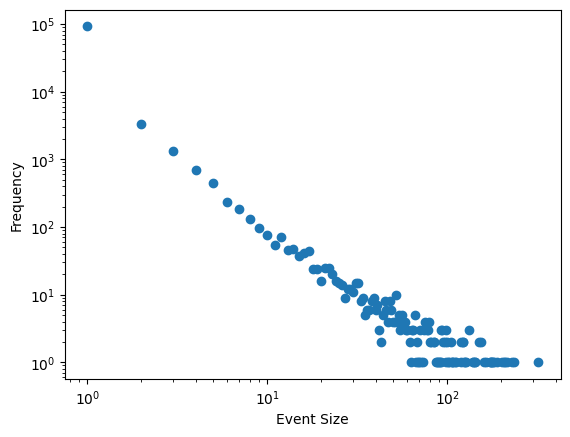

In [9]:
values, counts = np.unique(model.event_history, return_counts=True)
plt.scatter(values, counts)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Event Size')
plt.ylabel('Frequency')
plt.show()
